In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [15]:
#pip install -r requirements.txt

In [16]:
import torch

In [17]:
torch.cuda.is_available()

True

In [ ]:
from data_util import get_data_from_kaggle, sentiment_analysis , aggregate_tweet, restructure_date_information, get_static_df, one_label_scale_static_df, scale_stock_data
from constant import Constant
import pandas as pd
from torch import optim
from TFT import TFT_embedding, TFT, QuantilesLoss

In [19]:
TFT

TFT.tft.TFT

In [20]:
constant = Constant()
constant

In [21]:
stock, tweet = get_data_from_kaggle()

In [22]:
tweet = pd.read_csv('processed.csv')
#tweet

In [23]:
aggregated_tweet = aggregate_tweet(tweet)
aggregated_tweet

,Stock Name,Date,Positive_Avg,Neutral_Avg,Negative_Avg,Positive_Count,Neutral_Count,Negative_Count
0,AAPL,2021-09-30,0.322527,0.465190,0.212283,3,4,0
1,AAPL,2021-10-01,0.063409,0.574801,0.361790,0,8,3
2,AAPL,2021-10-02,0.053914,0.569441,0.376645,0,2,2
3,AAPL,2021-10-03,0.365725,0.546062,0.088213,0,1,0
4,AAPL,2021-10-04,0.082445,0.740438,0.177116,0,10,0
...,...,...,...,...,...,...,...,...
5905,ZS,2022-09-18,0.002347,0.195517,0.802136,0,0,1
5906,ZS,2022-09-21,0.025520,0.272998,0.701482,0,0,1
5907,ZS,2022-09-27,0.060069,0.497830,0.442101,0,1,0
5908,ZS,2022-09-28,0.129386,0.716569,0.154045,0,1,0


In [34]:
stock['Date'] = pd.to_datetime(stock['Date'] ).dt.date

In [36]:
stock_scaled, stock_scalar = scale_stock_data(stock, constant.columns_to_scale)

In [41]:
stock_scaled

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,0.257387,0.229337,0.258924,0.244819,0.244819,0.122630,TSLA
1,2021-10-01,0.253128,0.215174,0.239793,0.244387,0.244387,0.104561,TSLA
2,2021-10-04,0.282773,0.259596,0.260802,0.254873,0.254873,0.367441,TSLA
3,2021-10-05,0.263610,0.243211,0.257583,0.253311,0.253311,0.131943,TSLA
4,2021-10-06,0.249525,0.225147,0.255939,0.256901,0.256901,0.057687,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,0.012407,0.023899,0.025667,0.037305,0.037305,0.641919,XPEV
6296,2022-09-26,0.039747,0.045413,0.056417,0.052693,0.052693,0.631516,XPEV
6297,2022-09-27,0.046640,0.044725,0.043964,0.037305,0.037305,0.451202,XPEV
6298,2022-09-28,0.011488,0.013096,0.021347,0.028445,0.028445,0.736217,XPEV


In [51]:
stock_scalar['TSLA'].get_feature_names_out()

array(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'],
      dtype=object)

In [103]:
merged_df = pd.merge(aggregated_tweet, stock_scaled, on=['Date', 'Stock Name'], how='right')
merged_df = merged_df.fillna(0)

In [104]:
processed_df = restructure_date_information(merged_df)
#processed_df

In [105]:
static = get_static_df(processed_df,  constant.static_variables)

c:\Users\luanl\Documents\DL\TFT\data_util.py:74: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  static_df.fillna(0, inplace=True)


In [106]:
static[["sector", "country", "beta"]].loc["TSLA"].values

array(['Consumer Cyclical', 'United States', 2.295], dtype=object)

In [112]:
static_df = one_label_scale_static_df(static,constant.static_variables)

In [222]:
history_length = 60
prediction_length = 15
hidden_size = 128
batch_size = 128
dropout = .2
num_head = 4
lr= 0.0001
momentum=0.9
num_epochs = 30
max_grad_norm = 1

In [223]:
from data import TFT_Dataset
from torch.utils.data import DataLoader
tft_Dataset = TFT_Dataset(stock_df= processed_df , 
                static_df=static_df,
                constant_variable=constant, 
                history_length= history_length, 
                prediction_length= prediction_length)

In [224]:
loader = DataLoader(tft_Dataset, batch_size= batch_size)


In [225]:
count =0
for static_cont_input, static_cat_input,history_cont_input, history_cat_input, future_input, prediction in loader:
    count +=1
print(count)

35


In [226]:
from data_util import get_feature_length

history_cat_feature_num_list, history_cont_feature_num = get_feature_length(processed_df, constant.feature_variables)
static_cat_feature_num_list , static_cont_feature_num  = get_feature_length(static, constant.static_variables)
future_feature_num          , _                        = get_feature_length(processed_df, constant.future_feature)
_                           , prediction_con           = get_feature_length(processed_df, constant.prediction_feature)

In [227]:
history_cat_feature_num_list

[12, 31, 5, 52]

In [228]:
model = TFT(static_cat_feature_num_list= static_cat_feature_num_list,
            static_cont_feature_num=static_cont_feature_num,
            history_cat_feature_num_list= history_cat_feature_num_list,
            history_cont_feature_num=history_cont_feature_num,
            future_feature_list=future_feature_num,
            history_len = history_length,
            future_len = prediction_length,
            dropout= dropout,
            num_head = num_head,
            hidden_size = hidden_size)
model

TFT(
  (tft_embed): TFT_embedding(
    (static_cont): Linear(in_features=7, out_features=128, bias=True)
    (static_cat): ModuleList(
      (0): Embedding(16, 128)
      (1): Embedding(6, 128)
      (2): Embedding(3, 128)
    )
    (history_cont): Linear(in_features=11, out_features=128, bias=True)
    (history_cat): ModuleList(
      (0): Embedding(12, 128)
      (1): Embedding(31, 128)
      (2): Embedding(5, 128)
      (3): Embedding(52, 128)
    )
    (future_feature): ModuleList(
      (0): Embedding(12, 128)
      (1): Embedding(31, 128)
      (2): Embedding(5, 128)
      (3): Embedding(52, 128)
    )
  )
  (cs): VariationSelection(
    (group_GRN): GRN(
      (linear1): Linear(in_features=512, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=128, bias=True)
      (GLU): GLU(
        (linear4): Linear(in_features=128, out_features=512, bias=True)
        (linear5): Linear(in_features=128, out_features=512, bias=True)
      )
      (droput): Drop

In [229]:
loss_function = QuantilesLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [230]:
model.train()
batch_loss = [] 
for epoch in range(num_epochs):
    for i, (static_cont_input, static_cat_input,history_cont_input, history_cat_input, future_input, prediction) in enumerate(loader):
        predicted = model(static_cont_input, static_cat_input,history_cont_input, history_cat_input, future_input)
        optimizer.zero_grad()
        losses = loss_function(predicted = predicted, targets = prediction)
        loss = losses.sum()
        loss.backward()

        max_grad_norm = 1.0  # Set a threshold for the maximum gradient norm
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
    batch_loss.append(loss.item())

    print(f'Epoch: {epoch+1},  Loss: {loss.item()}')

Epoch: 1,  Loss: 0.19159719347953796
Epoch: 2,  Loss: 0.14133524894714355
Epoch: 3,  Loss: 0.1284409761428833
Epoch: 4,  Loss: 0.11209219694137573
Epoch: 5,  Loss: 0.10240529477596283
Epoch: 6,  Loss: 0.10073450207710266
Epoch: 7,  Loss: 0.10754389315843582
Epoch: 8,  Loss: 0.08717360347509384
Epoch: 9,  Loss: 0.08513037860393524
Epoch: 10,  Loss: 0.09098152816295624
Epoch: 11,  Loss: 0.07657614350318909
Epoch: 12,  Loss: 0.08841830492019653
Epoch: 13,  Loss: 0.09833256900310516
Epoch: 14,  Loss: 0.07862791419029236
Epoch: 15,  Loss: 0.06722637265920639
Epoch: 16,  Loss: 0.07159414887428284
Epoch: 17,  Loss: 0.0701071098446846
Epoch: 18,  Loss: 0.05609855055809021
Epoch: 19,  Loss: 0.057974524796009064
Epoch: 20,  Loss: 0.05545420944690704
Epoch: 21,  Loss: 0.06440550088882446
Epoch: 22,  Loss: 0.0782250463962555
Epoch: 23,  Loss: 0.06668292731046677
Epoch: 24,  Loss: 0.1500353217124939
Epoch: 25,  Loss: 0.0719432383775711
Epoch: 26,  Loss: 0.058103106915950775
Epoch: 27,  Loss: 0.0740

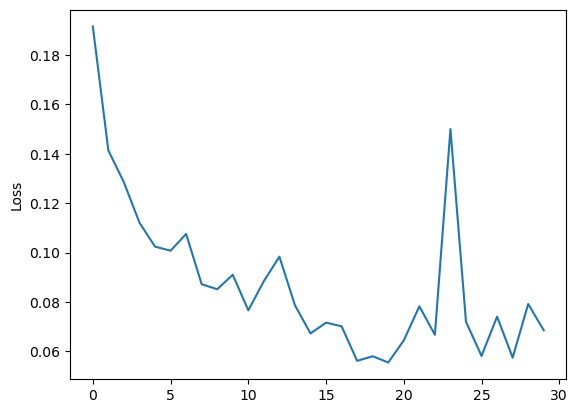

In [231]:
import matplotlib.pyplot as plt
x = range(len(batch_loss))
plt.plot(x, batch_loss)
plt.ylabel('Loss')
plt.show()